In [ ]:
%pip install numpy
%pip install matplotlib
%pip install scipy

In [ ]:
import numpy as np

def gradient_descent(A, B, lr=1e-3, num_iters=1000):
    m, n = A.shape
    X = np.zeros((n, B.shape[1] if B.ndim > 1 else 1))
    residual_history = []
    for k in range(num_iters):
        R = A.dot(X) - B
        grad = A.T.dot(R)
        X -= lr * grad
        residual_history.append(np.linalg.norm(R))
    return X, residual_history

In [11]:
def gradient_descent_momentum(A, B, lr=1e-3, momentum=0.9, num_iters=1000):
    m, n = A.shape
    X = np.zeros((n, B.shape[1] if B.ndim > 1 else 1))
    V = np.zeros_like(X)
    residual_history = []
    for k in range(num_iters):
        R = A.dot(X) - B
        grad = A.T.dot(R)
        V = momentum * V + lr * grad
        X -= V
        residual_history.append(np.linalg.norm(R))
    return X, residual_history

In [14]:
def gradient_descent_rmsprop(A, B, lr=1e-3, beta=0.9, num_iters=1000, eps=1e-8):
    m, n = A.shape
    X = np.zeros((n, B.shape[1] if B.ndim>1 else 1))
    S = np.zeros_like(X)
    residual_history = []
    for k in range(num_iters):
        R = A.dot(X) - B
        grad = A.T.dot(R)
        S = beta * S + (1 - beta) * (grad**2)
        X -= (lr * grad) / (np.sqrt(S) + eps)
        residual_history.append(np.linalg.norm(R))
    return X, residual_history

In [20]:
def gradient_descent_adam(A, B, lr=1e-3, beta1=0.9, beta2=0.999, num_iters=1000, eps=1e-8):
	m, n = A.shape
	X = np.zeros((n, B.shape[1] if B.ndim>1 else 1))
	M = np.zeros_like(X)   # first moment (grad avg)
	V = np.zeros_like(X)   # second moment (grad^2 avg)
	residual_history = []
	for k in range(1, num_iters+1):
		R = A.dot(X) - B
		grad = A.T.dot(R)
		M = beta1 * M + (1 - beta1) * grad
		V = beta2 * V + (1 - beta2) * (grad**2)
		M_hat = M / (1 - beta1**k)
		V_hat = V / (1 - beta2**k)
		X -= (lr * M_hat) / (np.sqrt(V_hat) + eps)
		residual_history.append(np.linalg.norm(R))
	return X, residual_history

In [21]:
def solve_tikhonov(A, B, lam=1e-3):
    n = A.shape[1]
    AtA = A.T.dot(A)
    reg_matrix = AtA + lam * np.eye(n)
    x = np.linalg.solve(reg_matrix, A.T.dot(B))
    return x

In [22]:
def solve_pseudoinverse(A, B):
    X = np.linalg.pinv(A).dot(B)
    return X

In [59]:
def solve_truncated_svd(A, B, r=None, tol=None):
    U, sigma, Vt = np.linalg.svd(A, full_matrices=False)
    if r is not None:
        # keep top-r singular values
        sigma[r:] = 0
    if tol is not None:
        # zero-out singular values below tolerance
        sigma[sigma < tol] = 0
    # Compute pseudoinverse of truncated Sigma
    sigma_inv = np.array([1 / s if s != 0 else 0 for s in sigma])
    # Recompose pseudoinverse solution
    X = Vt.T.dot(np.diag(sigma_inv)).dot(U.T).dot(B)
    return X

In [44]:
def solve_preconditioned_gd(A, B, num_iters=1000, lr=1e-3):
    # Preconditioner: inverse of diagonal of A (for simplicity, assume A square)
    D_inv = 1.0/np.diag(A)
    # Form preconditioned equivalents: A' = D_inv * A, B' = D_inv * B
    A_prime = (D_inv[:,None] * A)
    B_prime = (D_inv[:,None] * B)
    X, history = gradient_descent(A_prime, B_prime, lr=lr, num_iters=num_iters)
    return X, history

In [58]:
def conjugate_gradient(A, b, tol=1e-10, max_iters=None):
    """Conjugate Gradient solver for symmetric positive-definite A."""
    n = A.shape[0]
    if max_iters is None:
        max_iters = n
    x = np.zeros_like(b)
    r = b - A.dot(x)
    p = r.copy()
    rs_old = r.T.dot(r)
    for i in range(max_iters):
        Ap = A.dot(p)
        alpha = rs_old / (p.T.dot(Ap))
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = r.T.dot(r)
        if np.sqrt(rs_new) < tol:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

Well-conditioned GD
Final residue is: 0.0030877918991256653
Final error is: 0.003075440730050379
Well-conditioned Momentum
Final residue is: 1.526548301764105e-11
Final error is: 6.06709092933577e-12
Well-conditioned RMSProp
Final residue is: 0.5284357779564005
Final error is: 0.11180339351506373
Well-conditioned Adam
Final residue is: 0.007358773982038832
Final error is: 0.0007284742894763958


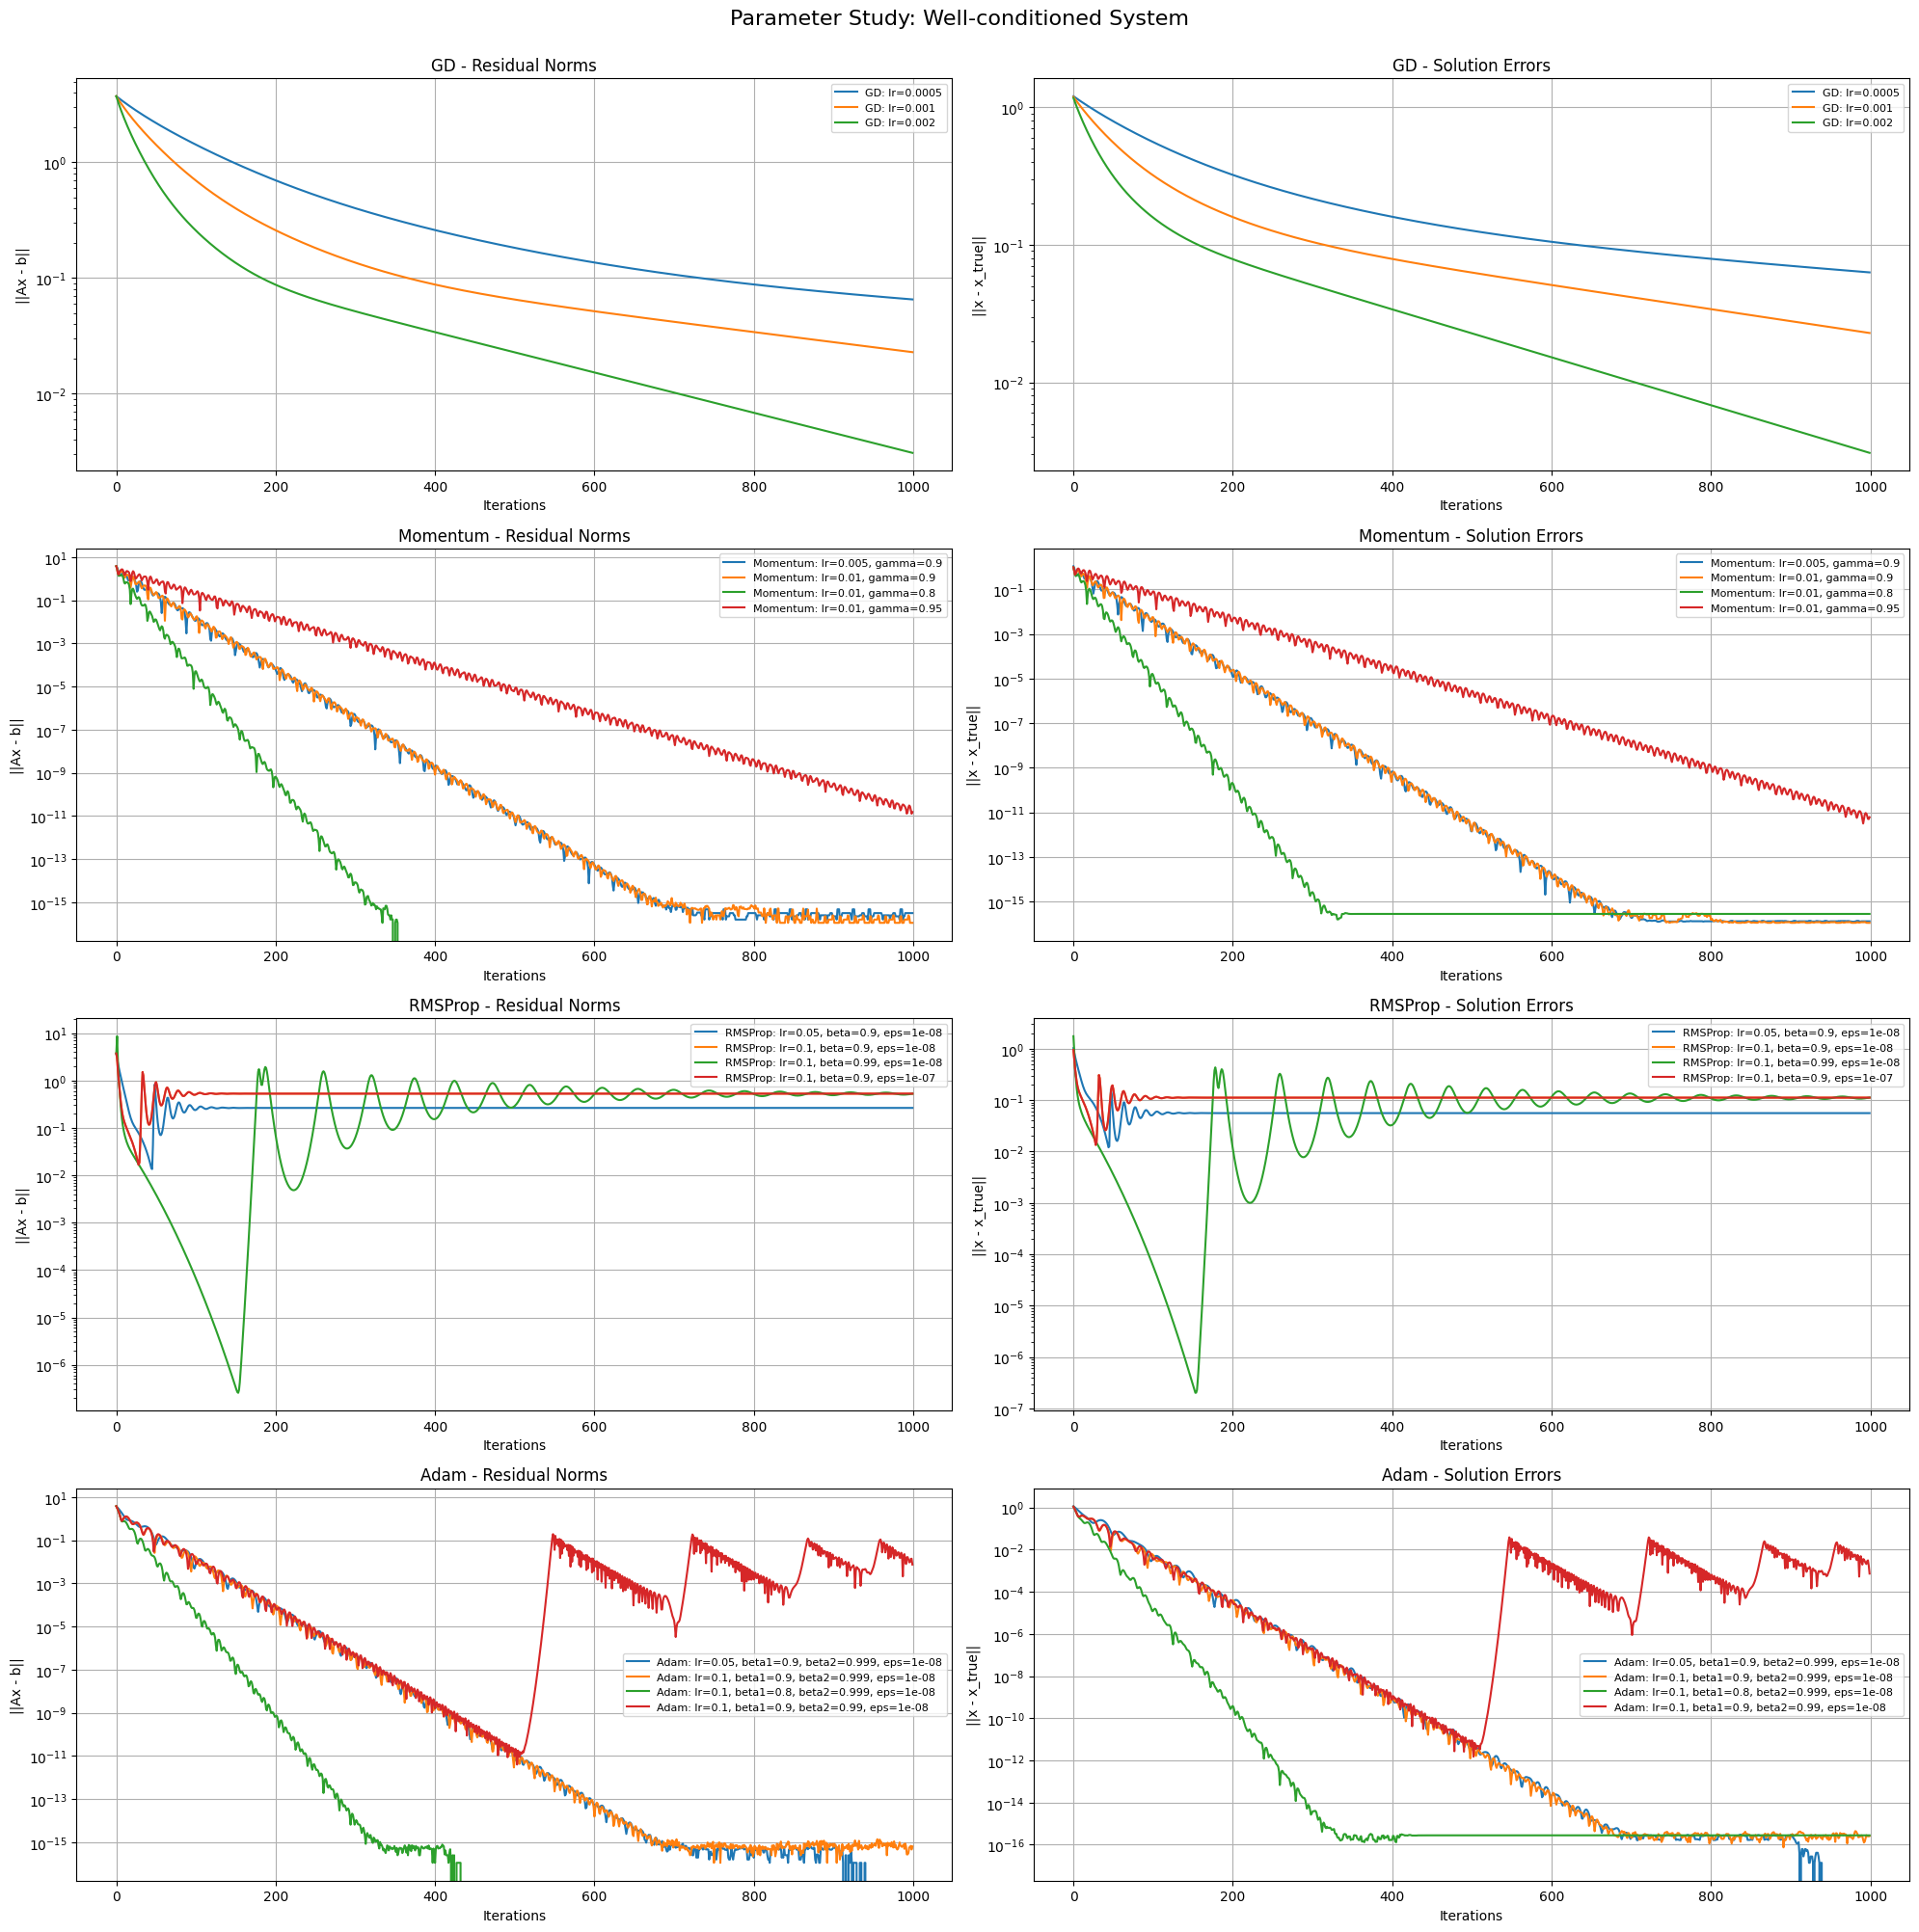

Ill-conditioned GD
Final residue is: 0.07002787251015732
Final error is: 0.497041728463409
Ill-conditioned Momentum
Final residue is: 0.0028621395544151033
Final error is: 0.15429587488139332
Ill-conditioned RMSProp
Final residue is: 0.2073328276286715
Final error is: 0.1414212725620795
Ill-conditioned Adam
Final residue is: 0.0031809324852607413
Final error is: 0.0018265864665235432


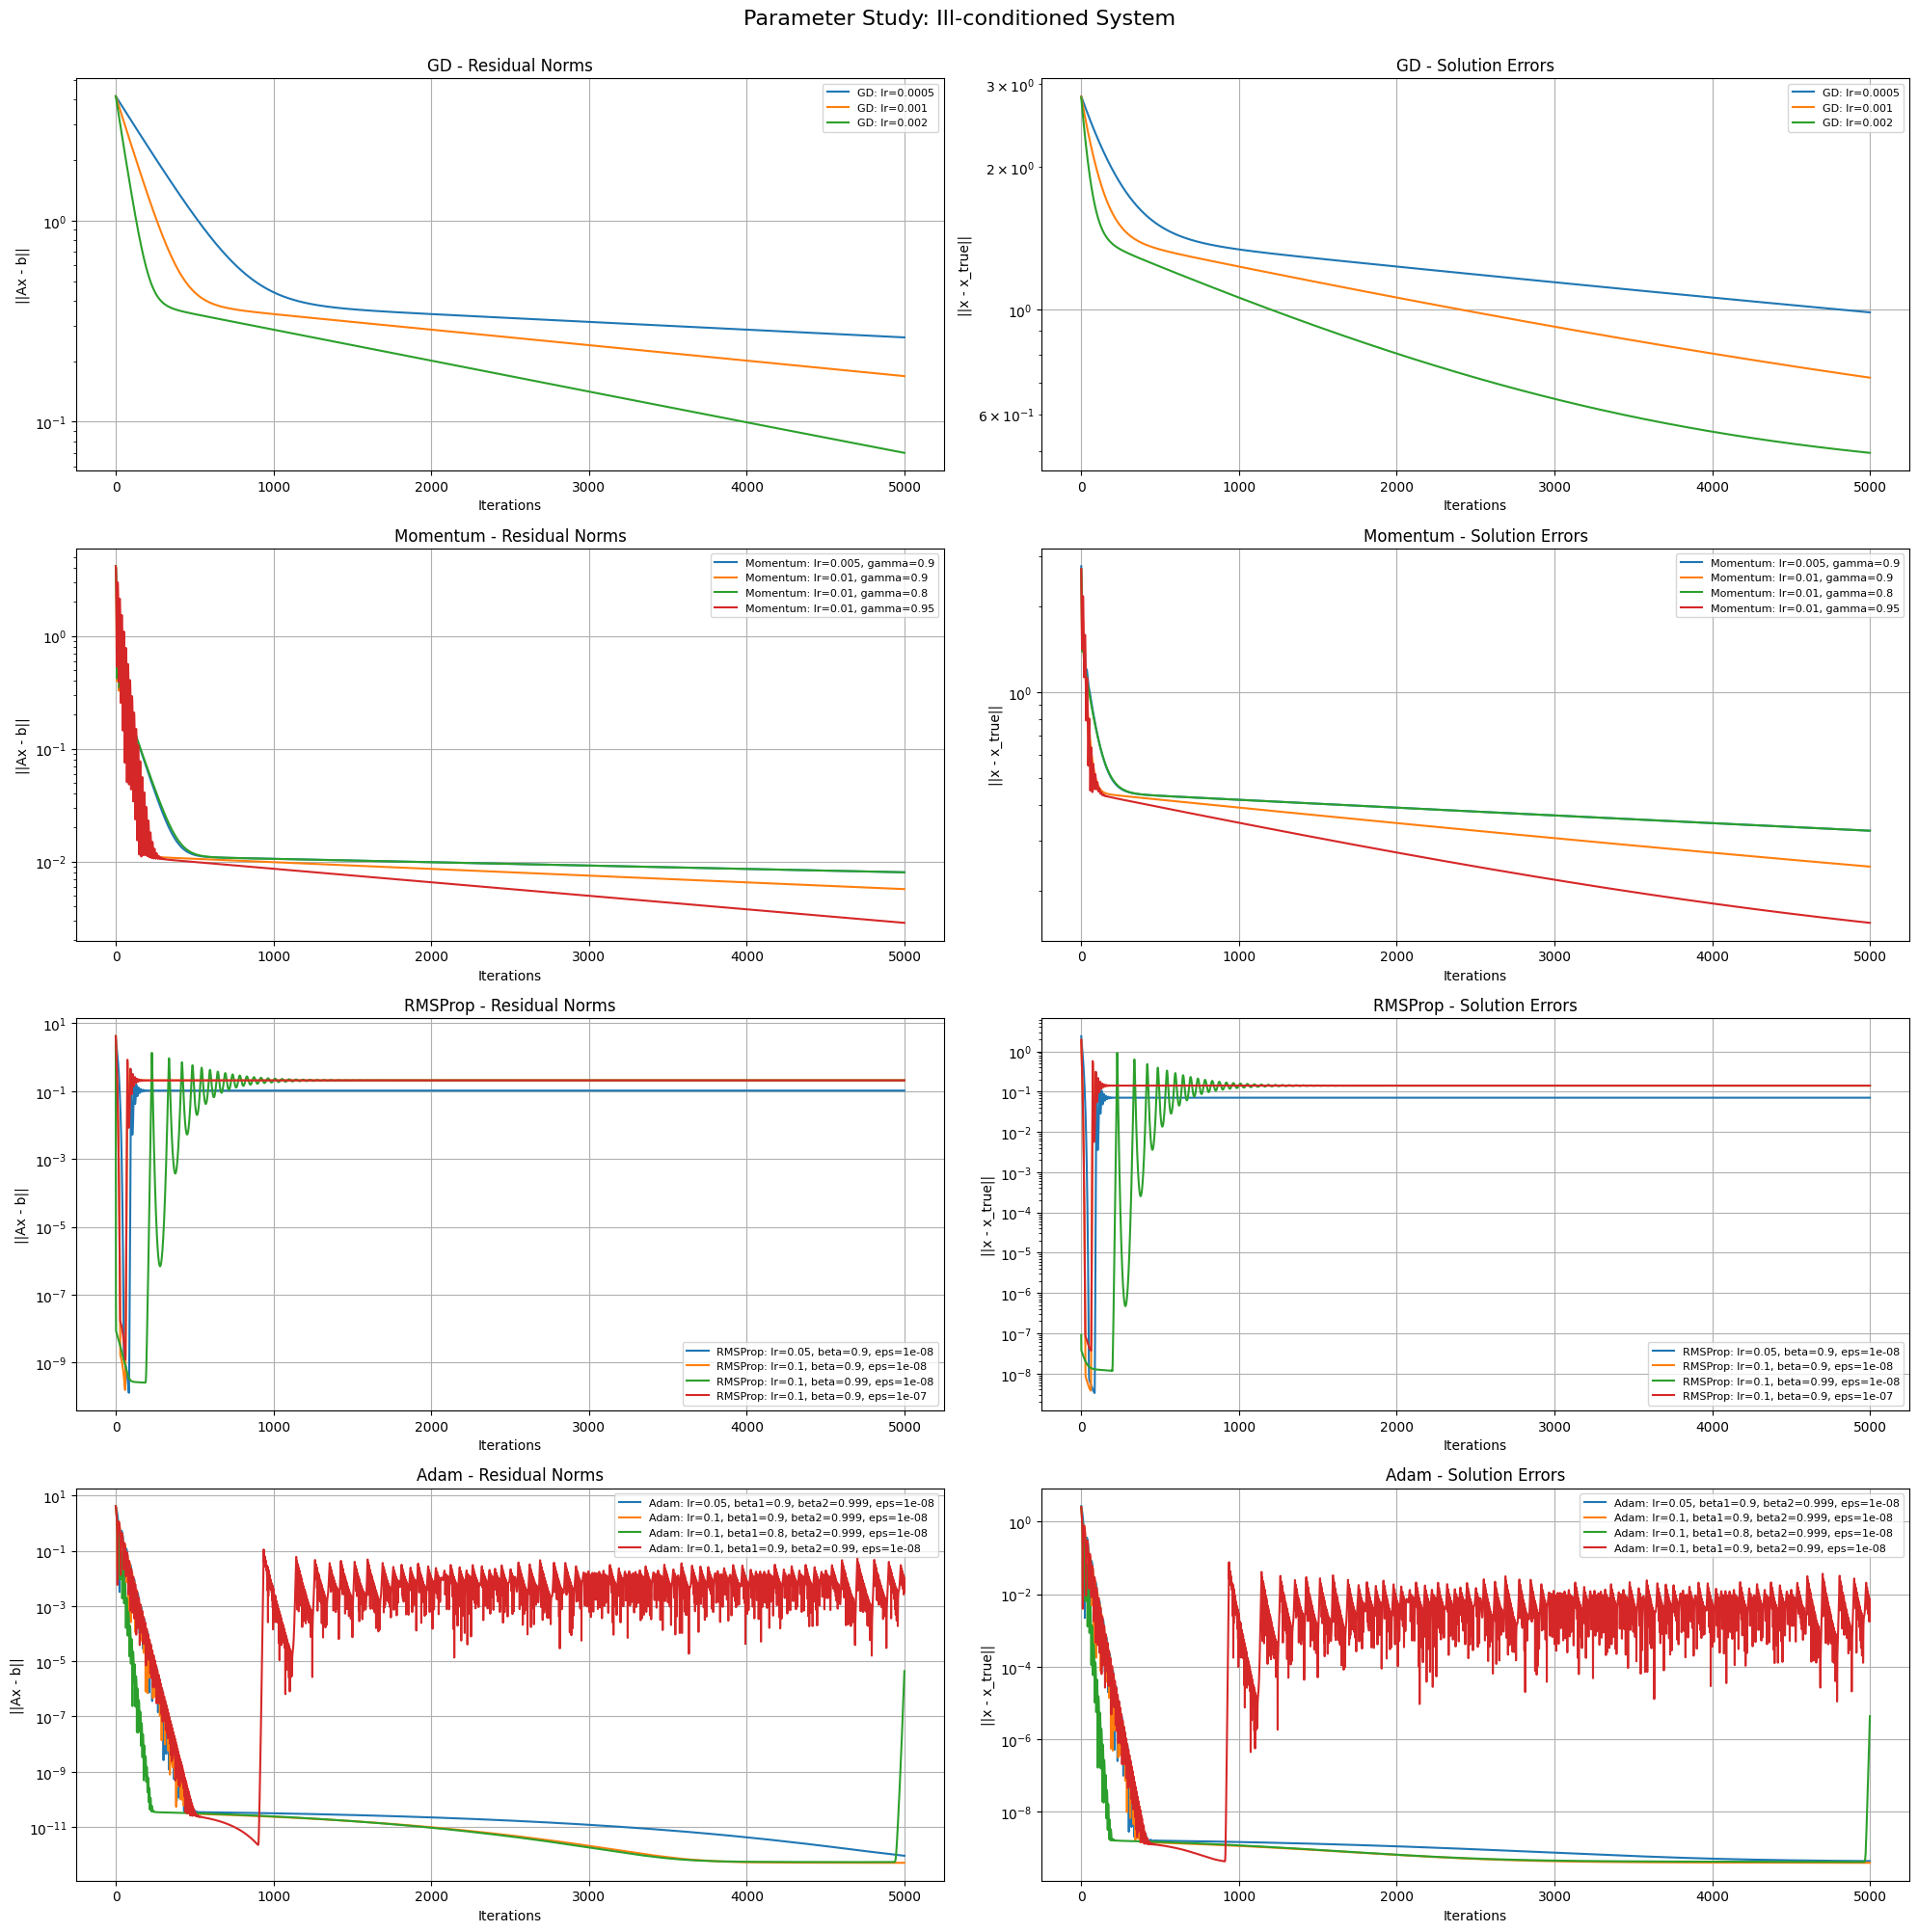

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hilbert

def generate_well_conditioned(n=5):
    U, _ = np.linalg.qr(np.random.randn(n, n))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    s = np.linspace(1, 5, n)  # Condition number ~5
    return U @ np.diag(s) @ V.T

def generate_hilbert(n=8):
    return hilbert(n)

def run_optimizer(optimizer, A, b, params, max_iter, x_true):
    if optimizer == "GD":
        lr = params['lr']
        _, residuals, errors = gd(A, b, lr, max_iter, x_true)
    elif optimizer == "Momentum":
        lr = params['lr']
        gamma = params['gamma']
        _, residuals, errors = momentum_gd(A, b, lr, gamma, max_iter, x_true)
    elif optimizer == "RMSProp":
        lr = params['lr']
        beta = params['beta']
        eps = params['eps']
        _, residuals, errors = rmsprop(A, b, lr, beta, eps, max_iter, x_true)
    elif optimizer == "Adam":
        lr = params['lr']
        beta1 = params['beta1']
        beta2 = params['beta2']
        eps = params['eps']
        _, residuals, errors = adam(A, b, lr, beta1, beta2, eps, max_iter, x_true)
    return residuals, errors

# Experiment setup
systems = {
    "Well-conditioned": {
        "A": generate_well_conditioned(),
        "x_true": np.random.randn(5),
        "max_iter": 1000
    },
    "Ill-conditioned": {
        "A": generate_hilbert(),
        "x_true": np.ones(8),
        "max_iter": 5000
    }
}

param_config = {
    "GD": [
        {"lr": 0.0005},
        {"lr": 0.001},
        {"lr": 0.002}
    ],
    "Momentum": [
        {"lr": 0.005, "gamma": 0.9},
        {"lr": 0.01, "gamma": 0.9},
        {"lr": 0.01, "gamma": 0.8},
        {"lr": 0.01, "gamma": 0.95}
    ],
    "RMSProp": [
        {"lr": 0.05, "beta": 0.9, "eps": 1e-8},
        {"lr": 0.1, "beta": 0.9, "eps": 1e-8},
        {"lr": 0.1, "beta": 0.99, "eps": 1e-8},
        {"lr": 0.1, "beta": 0.9, "eps": 1e-7}
    ],
    "Adam": [
        {"lr": 0.05, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8},
        {"lr": 0.1, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8},
        {"lr": 0.1, "beta1": 0.8, "beta2": 0.999, "eps": 1e-8},
        {"lr": 0.1, "beta1": 0.9, "beta2": 0.99, "eps": 1e-8}
    ]
}

# Main experiment loop
for system_name, system in systems.items():
    A = system["A"]
    x_true = system["x_true"]
    b = A @ x_true
    max_iter = system["max_iter"]
    
    fig, axs = plt.subplots(4, 2, figsize=(20, 20))
    plt.suptitle(f"Parameter Study: {system_name} System", y=1.0, fontsize=16)
    
    for row, (optimizer, params_list) in enumerate(param_config.items()):
        ax_res = axs[row, 0]
        ax_err = axs[row, 1]
        
        for params in params_list:
            residuals, errors = run_optimizer(
                optimizer, A, b, params, max_iter, x_true
            )
            
            label_parts = [f"{k}={v}" for k,v in params.items()]
            label = f"{optimizer}: " + ", ".join(label_parts)
            
            ax_res.semilogy(residuals, label=label)
            ax_err.semilogy(errors, label=label)
        print(system_name, optimizer)
        print(f'Final residue is: {residuals[-1]}')
        print(f'Final error is: {errors[-1]}')
        ax_res.set_title(f"{optimizer} - Residual Norms")
        ax_res.set_xlabel("Iterations")
        ax_res.set_ylabel("||Ax - b||")
        ax_res.legend(fontsize=8)
        ax_res.grid(True)
        
        ax_err.set_title(f"{optimizer} - Solution Errors")
        ax_err.set_xlabel("Iterations")
        ax_err.set_ylabel("||x - x_true||")
        ax_err.legend(fontsize=8)
        ax_err.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{system_name.replace(' ', '_')}_parameter_study.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
from scipy.sparse.linalg import cg

# Define the singular system
A = np.array([[1, 2], [2, 4]], dtype=np.float64)
b = np.array([5, 10], dtype=np.float64)
x_true_pinv = np.array([1, 2])  # Minimum-norm solution

# Method 1: Direct solver (np.linalg.solve)
try:
    x_solve = np.linalg.solve(A, b)
except np.linalg.LinAlgError as e:
    x_solve = f"Error: {str(e)}"

# Method 2: Pseudoinverse (np.linalg.pinv)
x_pinv = np.linalg.pinv(A) @ b

# Method 3: Gradient Descent
def gradient_descent(A, b, lr=0.01, max_iter=10000, tol=1e-8):
    x = np.zeros(A.shape[1])
    residuals = []
    for _ in range(max_iter):
        residual = A @ x - b
        grad = 2 * A.T @ residual
        x -= lr * grad
        residuals.append(np.linalg.norm(residual))
        if np.linalg.norm(grad) < tol:
            break
    return x, residuals

x_gd, res_gd = gradient_descent(A, b)

# Method 4: Regularization (Ridge Regression)
lambda_ = 0.01
x_ridge = np.linalg.inv(A.T @ A + lambda_ * np.eye(2)) @ A.T @ b

# Method 5: Truncated SVD
U, s, Vt = np.linalg.svd(A, full_matrices=False)
s_truncated = np.array([s[0], 0])  # Drop the zero singular value
A_trunc = U @ np.diag(s_truncated) @ Vt
x_svd = np.linalg.pinv(A_trunc) @ b

# Method 6: Moore-Penrose via SVD (Manual)
U, s, Vt = np.linalg.svd(A, full_matrices=False)
s_plus = np.zeros_like(s)
s_plus[s > 1e-10] = 1 / s[s > 1e-10]  # Avoid division by zero
x_manual_svd = Vt.T @ np.diag(s_plus) @ U.T @ b

# Method 7: Preconditioning (Row Scaling)
row_norms = np.linalg.norm(A, axis=1)
D = np.diag(1 / row_norms)
A_scaled = D @ A
b_scaled = D @ b
x_gd_scaled, _ = gradient_descent(A_scaled, b_scaled)

# Method 8: Conjugate Gradient (on A^T A x = A^T b)
ATA = A.T @ A
ATb = A.T @ b
x_cg, info = cg(ATA, ATb, rtol=1e-8)

print("===== Results =====")
print(f"Direct solve:\n{x_solve}\n")
print(f"Pseudoinverse solution:\n{x_pinv}\n")
print(f"Gradient Descent solution:\n{x_gd}\n")
print(f"Ridge Regression (λ={lambda_}):\n{x_ridge}\n")
print(f"Truncated SVD solution:\n{x_svd}\n")
print(f"Manual SVD Pseudoinverse:\n{x_manual_svd}\n")
print(f"Preconditioned GD solution:\n{x_gd_scaled}\n")
print(f"Conjugate Gradient solution:\n{x_cg}\n")

plt.figure(figsize=(10, 5))
plt.semilogy(res_gd)
plt.xlabel("Iterations")
plt.ylabel("Residual Norm (log scale)")
plt.title("Gradient Descent Convergence")
plt.grid()
plt.savefig("gd_convergence.png", dpi=300)
plt.close()

===== Results =====
Direct solve:
Error: Singular matrix

Pseudoinverse solution:
[1. 2.]

Gradient Descent solution:
[1. 2.]

Ridge Regression (λ=0.01):
[0.99960016 1.99920032]

Truncated SVD solution:
[1. 2.]

Manual SVD Pseudoinverse:
[1. 2.]

Preconditioned GD solution:
[1. 2.]

Conjugate Gradient solution:
[1. 2.]



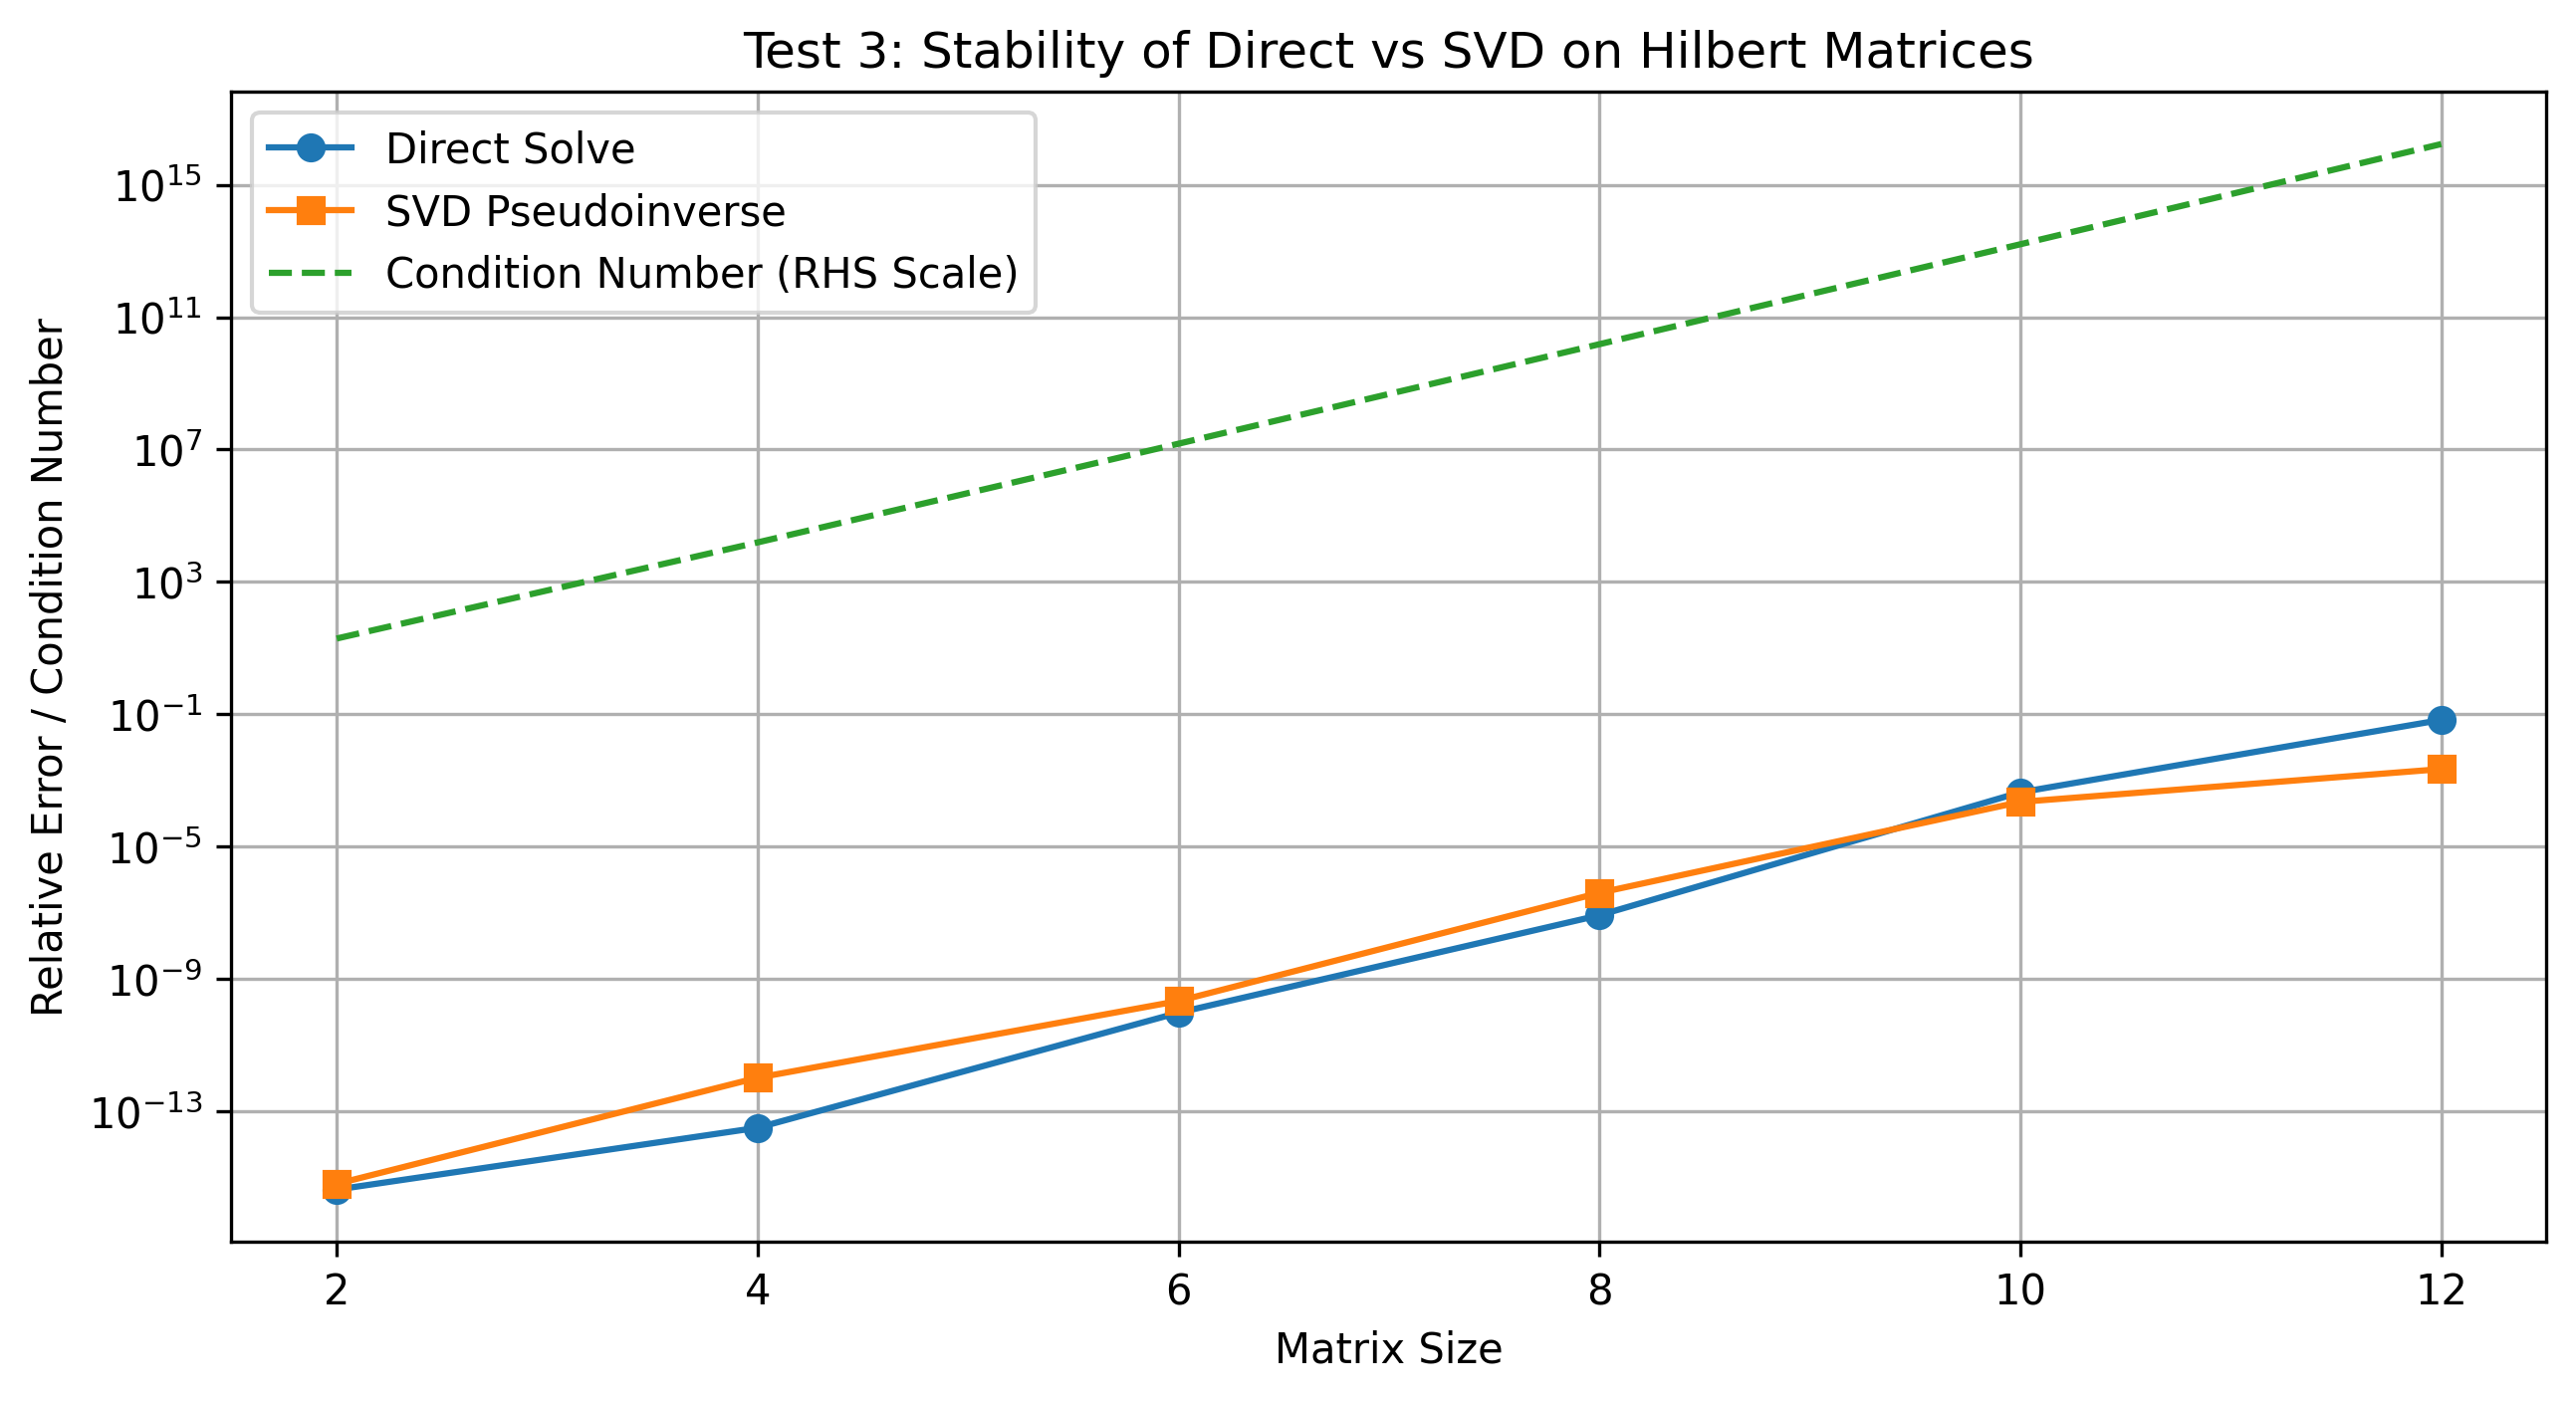

/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_79205/2669447357.py:60: RuntimeWarning: overflow encountered in matmul
  grad = 2 * A.T @ residual
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_79205/2669447357.py:60: RuntimeWarning: invalid value encountered in matmul
  grad = 2 * A.T @ residual
/var/folders/km/y1gjflc56rd069hf7r__rftc0000gn/T/ipykernel_79205/2669447357.py:61: RuntimeWarning: invalid value encountered in subtract
  x -= lr * grad


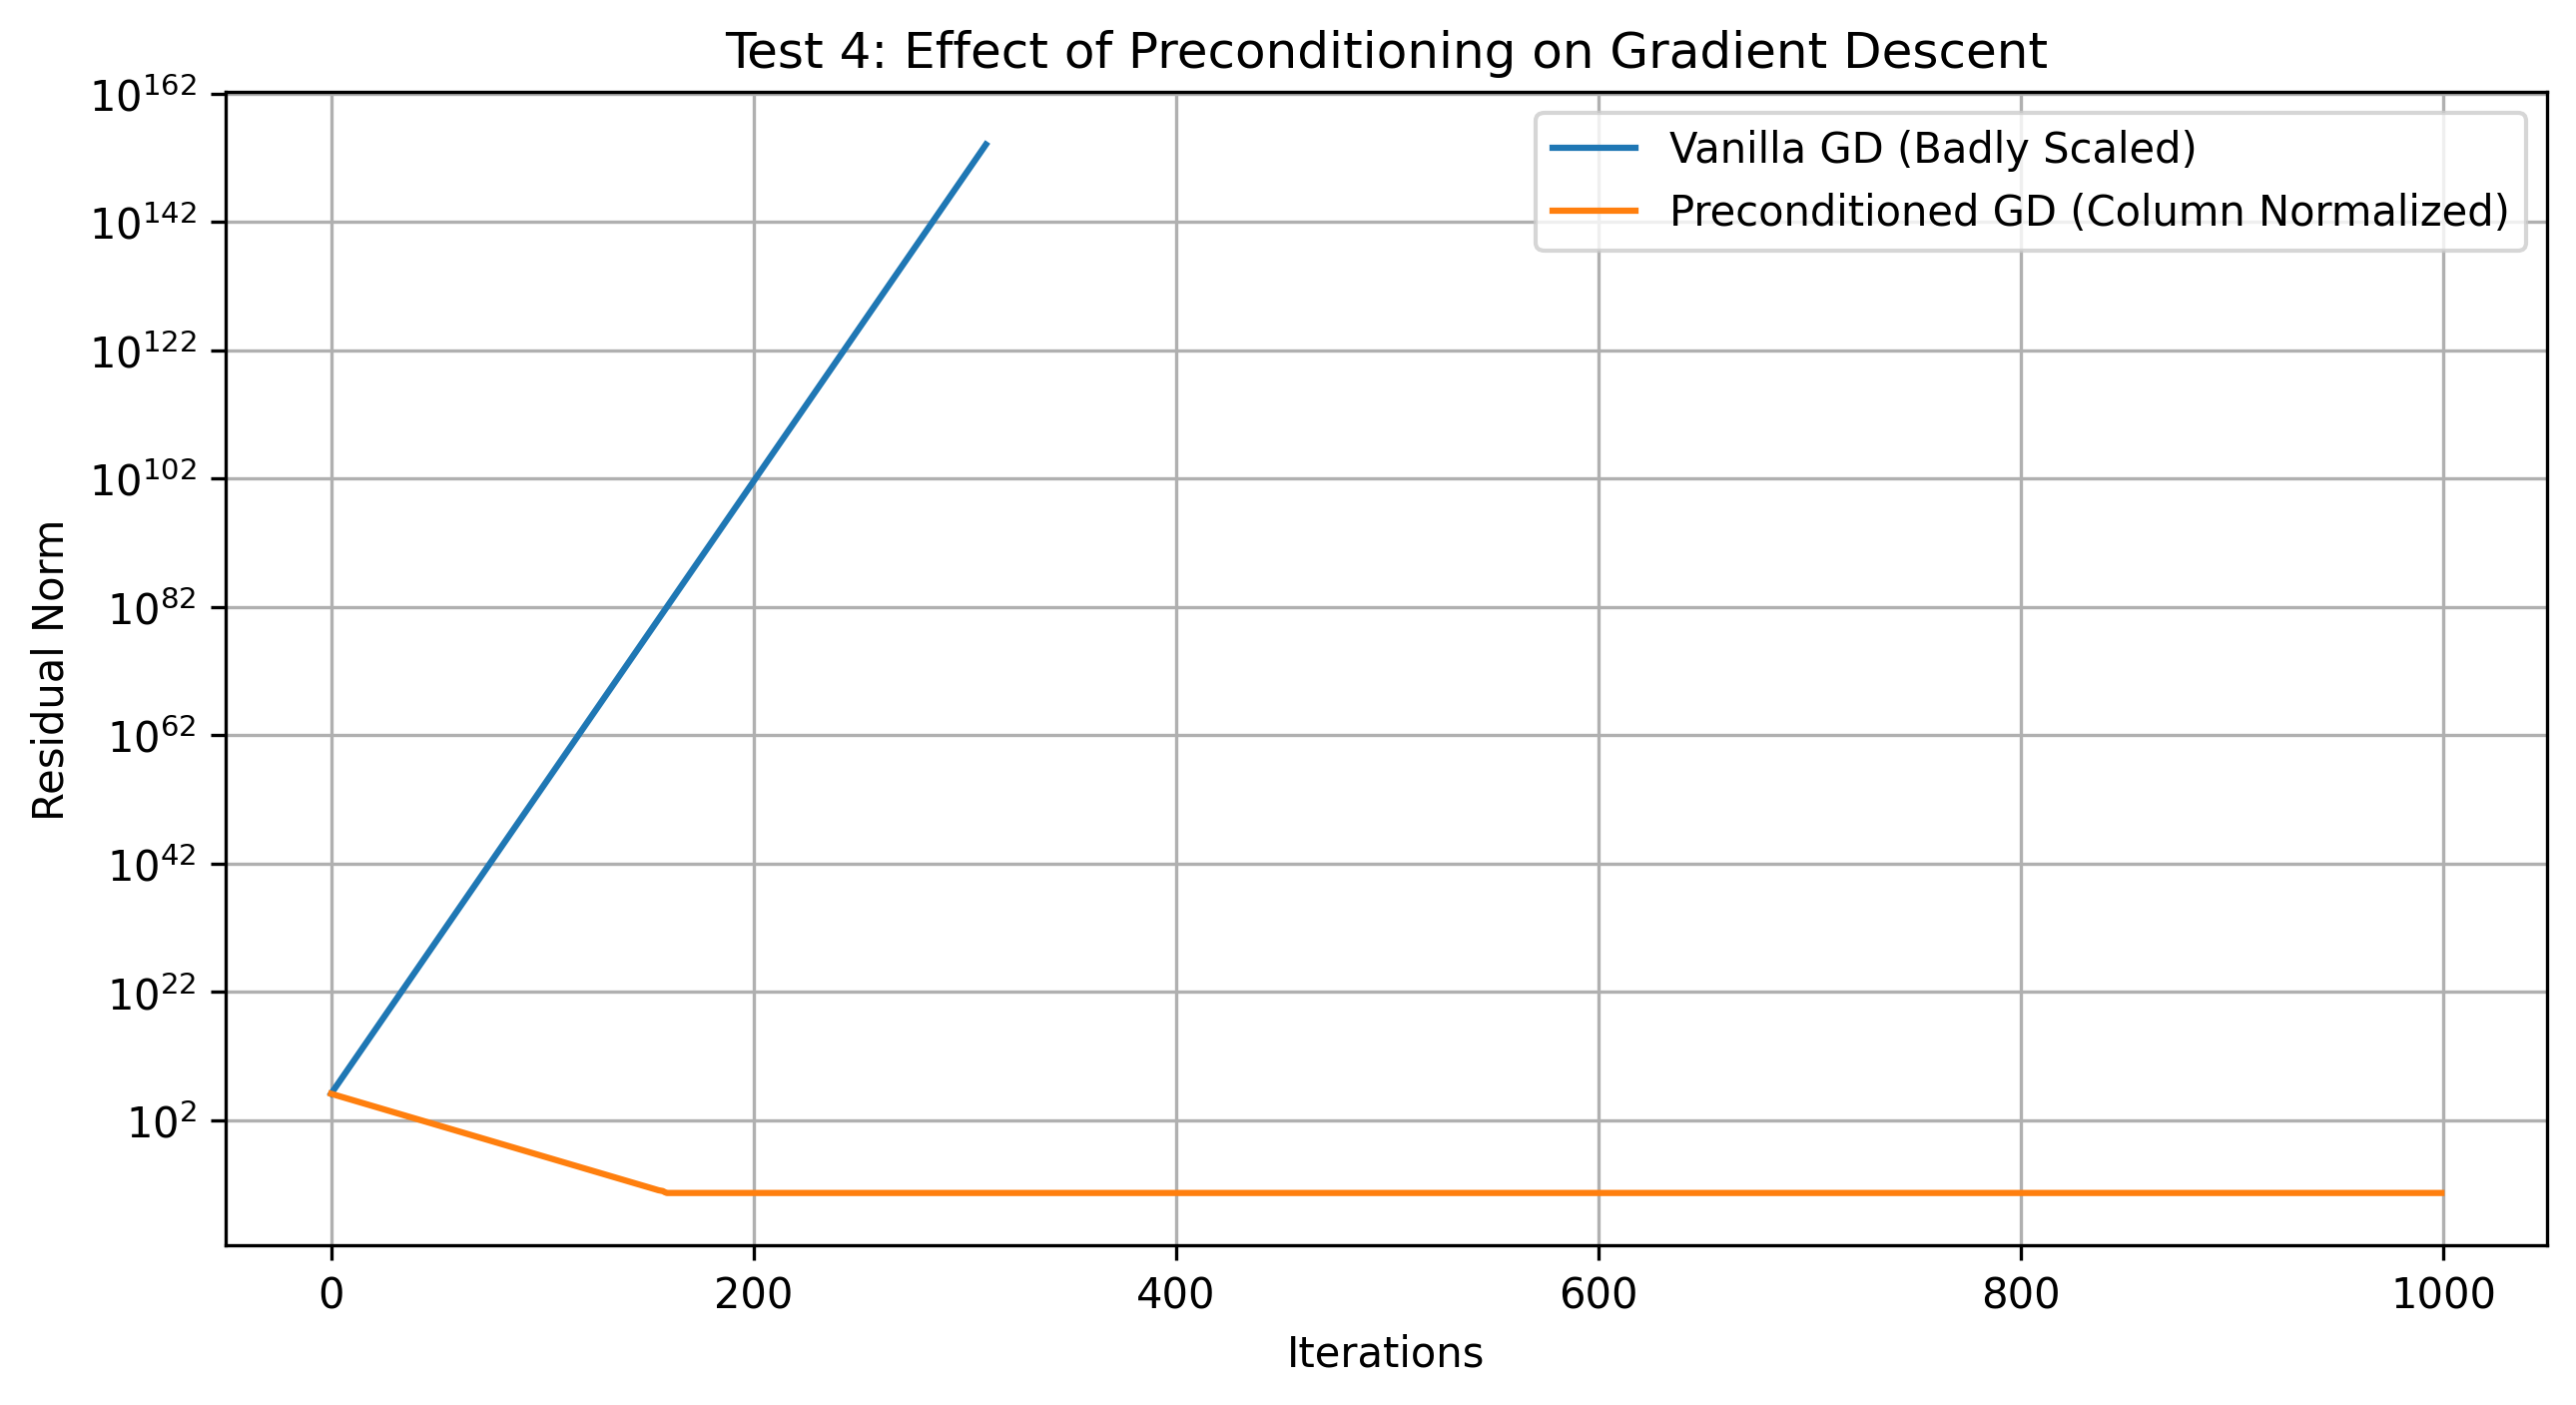

===== Test 3 Results =====
12x12 Hilbert Matrix:
  Direct Solve Error: 6.68e-02
  SVD Error: 2.18e-03
  Condition Number: 1.71e+16

===== Test 4 Results =====
Vanilla GD Final Residual: nan
Preconditioned GD Final Residual: 4.94e-10


In [64]:
# Test 3: Ill-conditioned matrix stability
sizes = [2, 4, 6, 8, 10, 12]
direct_errors = []
svd_errors = []
condition_numbers = []

for n in sizes:
    H = hilbert(n)
    x_true = np.ones(n)
    b = H @ x_true
    
    # Compute condition number
    cond = np.linalg.cond(H)
    condition_numbers.append(cond)
    
    # Direct solve
    try:
        x_direct = np.linalg.solve(H, b)
        direct_error = np.linalg.norm(x_direct - x_true) / np.linalg.norm(x_true)
    except np.linalg.LinAlgError:
        x_direct = np.linalg.lstsq(H, b, rcond=None)[0]
        direct_error = np.linalg.norm(x_direct - x_true) / np.linalg.norm(x_true)
    direct_errors.append(direct_error)
    
    # SVD solve
    x_svd = np.linalg.pinv(H) @ b
    svd_error = np.linalg.norm(x_svd - x_true) / np.linalg.norm(x_true)
    svd_errors.append(svd_error)

plt.figure(figsize=(10, 5), dpi=300)
plt.semilogy(sizes, direct_errors, 'o-', label='Direct Solve')
plt.semilogy(sizes, svd_errors, 's-', label='SVD Pseudoinverse')
plt.semilogy(sizes, condition_numbers, '--', label='Condition Number (RHS Scale)')
plt.xlabel('Matrix Size')
plt.ylabel('Relative Error / Condition Number')
plt.title('Test 3: Stability of Direct vs SVD on Hilbert Matrices')
plt.legend()
plt.grid()
plt.savefig('test3_stability.png', dpi=300)
plt.show()

# Test 4: Preconditioning effect
np.random.seed(42)
n = 2
A = np.array([[1e6, 1], [1e6, -1]], dtype=np.float64)  # Badly scaled columns
x_true = np.array([1.0, 2.0])
b = A @ x_true

# Preconditioning: Column scaling
col_norms = np.linalg.norm(A, axis=0)
A_scaled = A / col_norms
x_true_scaled = x_true * col_norms  # Adjust true solution for scaling

# Gradient Descent
def gradient_descent(A, b, lr=0.01, max_iter=1000):
    x = np.zeros(A.shape[1])
    residuals = []
    for _ in range(max_iter):
        residual = A @ x - b
        grad = 2 * A.T @ residual
        x -= lr * grad
        residuals.append(np.linalg.norm(residual))
    return residuals

# Run on original and scaled systems
res_vanilla = gradient_descent(A, b, lr=1e-12)
res_scaled = gradient_descent(A_scaled, b, lr=0.1)

plt.figure(figsize=(10, 5), dpi=300)
plt.semilogy(res_vanilla, label='Vanilla GD (Badly Scaled)')
plt.semilogy(res_scaled, label='Preconditioned GD (Column Normalized)')
plt.xlabel('Iterations')
plt.ylabel('Residual Norm')
plt.title('Test 4: Effect of Preconditioning on Gradient Descent')
plt.legend()
plt.grid()
plt.savefig('test4_preconditioning.png', dpi=300)
plt.show()

print("===== Test 3 Results =====")
print(f"12x12 Hilbert Matrix:")
print(f"  Direct Solve Error: {direct_errors[-1]:.2e}")
print(f"  SVD Error: {svd_errors[-1]:.2e}")
print(f"  Condition Number: {condition_numbers[-1]:.2e}\n")

print("===== Test 4 Results =====")
print(f"Vanilla GD Final Residual: {res_vanilla[-1]:.2e}")
print(f"Preconditioned GD Final Residual: {res_scaled[-1]:.2e}")